In [21]:
'''
    Accessing the required packages
'''
import warnings
warnings.filterwarnings("ignore")

#basic
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm
import joblib
import os

#xgboost and other
from xgboost import XGBClassifier
from collections import defaultdict

#sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer 
from scipy.sparse import hstack
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix 

#nltk 
from gensim.models import Word2Vec
import nltk

# plots
import seaborn as sns
import matplotlib.pyplot as plt
#pretty print table
from prettytable import PrettyTable

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [ ]:
#Accessing data
preprocessed_data = pd.read_csv("preprocessed_data.csv")

#getting dependent and indepenent variables
Y_data = preprocessed_data['project_is_approved']
X_data = preprocessed_data.drop(['project_is_approved'], axis=1)

#doing train test split
preprocessed_train_df,preprocessed_test_df,preprocessed_train_Y,preprocessed_test_Y = train_test_split(preprocessed_data,preprocessed_data['project_is_approved'],stratify=preprocessed_data['project_is_approved'],test_size=0.2)
preprocessed_train_df,cv_df,preprocessed_train_Y,cv_Y = train_test_split(preprocessed_train_df,preprocessed_train_df["project_is_approved"],stratify=preprocessed_train_df["project_is_approved"] ,test_size=0.2)


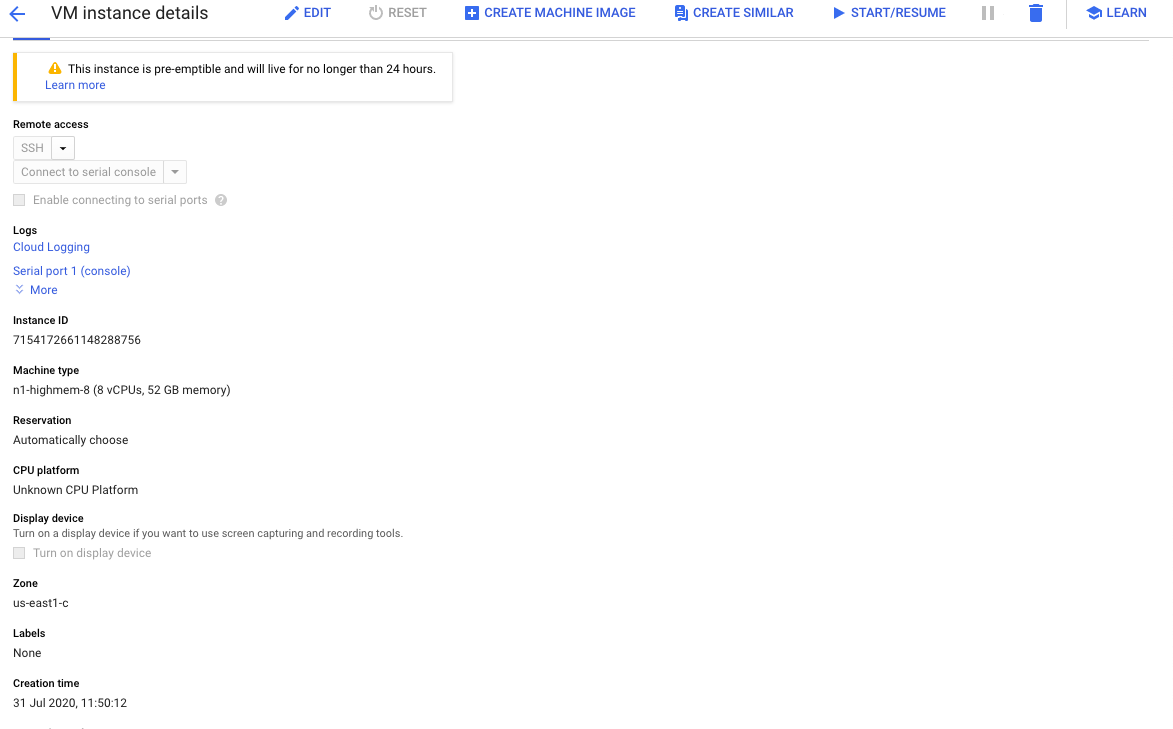

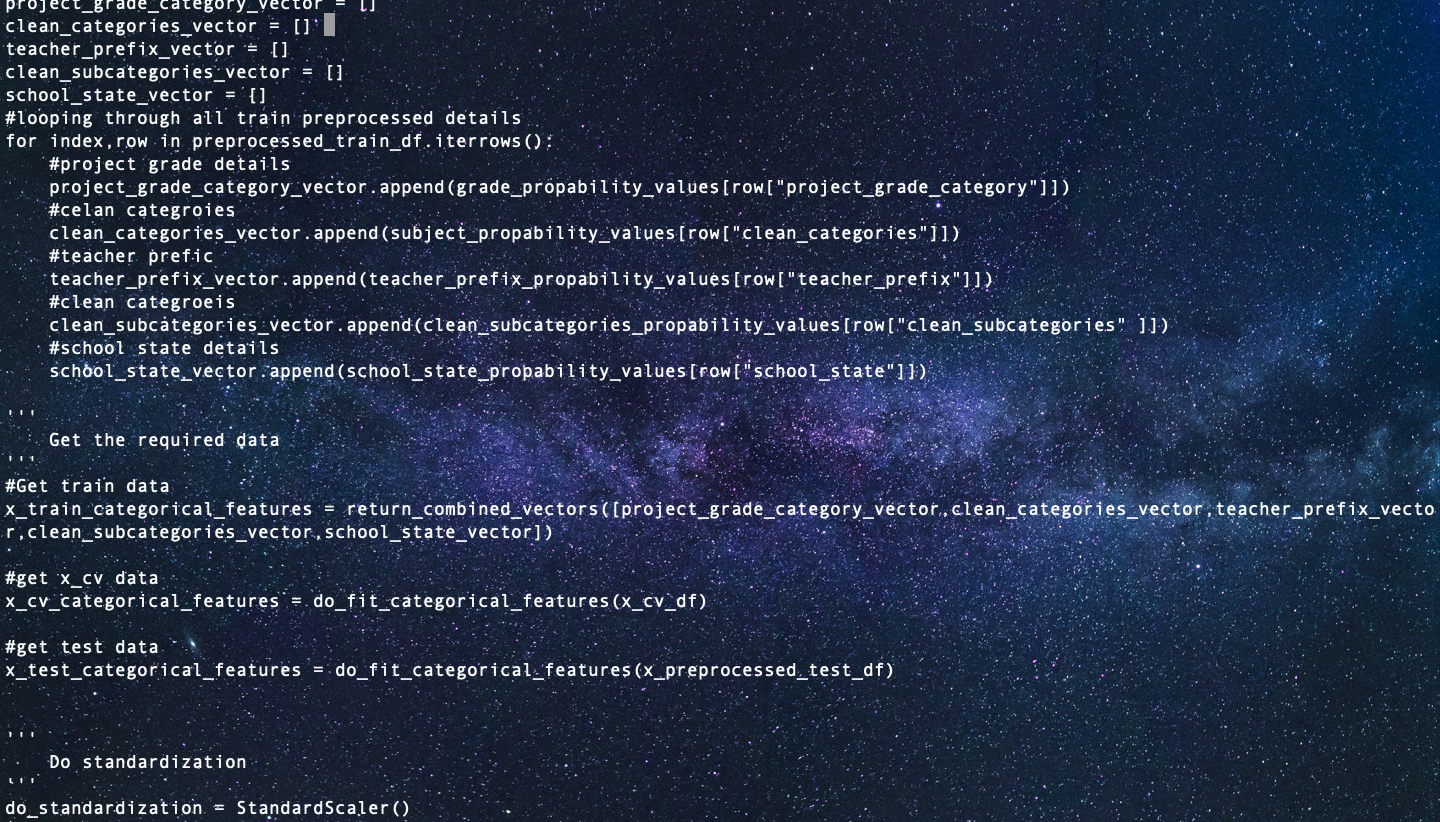

## Instead of colab i runed on ther server for doign experiemnts

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

In [ ]:

def get_probability_values_for_each_feature(feature,preprocessed_train_df,alpha=10): 
  #doing preprocessed data
  value_count_for_each_feature = preprocessed_train_df[feature].value_counts() 
  set_feature_dictionary = {}
  target_classes = (0,1)
  #looping through feature details
  for feat,cnt in value_count_for_each_feature.items(): 
    feature_class_probabilities = []
    #looping through target variable details
    for cls in target_classes:
        records_found_with_class_matching = preprocessed_train_df[(preprocessed_train_df[feature] == feat) & (preprocessed_train_df["project_is_approved"] == cls)].shape[0]
        feature_class_probabilities.append((records_found_with_class_matching + alpha)/(cnt + (alpha * 2)))
    set_feature_dictionary[feat] = feature_class_probabilities
  return set_feature_dictionary

#initilaizing the reqiured values
grade_propability_values = {} 
subject_propability_values = {} 
teacher_prefix_propability_values = {} 
clean_subcategories_propability_values = {} 
school_state_propability_values = {}

''' 
    Calculate propabilty values for all categorical features 
'''
grade_propability_values = get_probability_values_for_each_feature("project_grade_category",preprocessed_train_df)
subject_propability_values = get_probability_values_for_each_feature("clean_categories",preprocessed_train_df)
teacher_prefix_propability_values = get_probability_values_for_each_feature("teacher_prefix",preprocessed_train_df)
clean_subcategories_propability_values = get_probability_values_for_each_feature("clean_subcategories",preprocessed_train_df)
school_state_propability_values = get_probability_values_for_each_feature("school_state",preprocessed_train_df)


In [ ]:
'''
    Code is referenced from stackoverflow
'''
def return_combined_vectors(fecVect):
    #first combine first two vetors
    get_combinedFeatures = np.hstack((fecVect[0],fecVect[1]))
    #combing the required vectors with first two detaisl
    for i in range(2,len(fecVect)):
        get_combinedFeatures = np.hstack((get_combinedFeatures,fecVect[i]))
    return get_combinedFeatures

In [ ]:
project_grade_category_vector = [] 
clean_categories_vector = [] 
teacher_prefix_vector = [] 
clean_subcategories_vector = [] 
school_state_vector = []
#looping through all train preprocessed details
for index,row in preprocessed_train_df.iterrows():
    #project grade details
    project_grade_category_vector.append(grade_propability_values[row["project_grade_category"]])
    #celan categroies
    clean_categories_vector.append(subject_propability_values[row["clean_categories"]]) 
    #teacher prefic
    teacher_prefix_vector.append(teacher_prefix_propability_values[row["teacher_prefix"]])
    #clean categroeis
    clean_subcategories_vector.append(clean_subcategories_propability_values[row["clean_subcategories" ]])
    #school state details
    school_state_vector.append(school_state_propability_values[row["school_state"]])
train_categoeical_x = get_hstacked_vectors([project_grade_category_vector,clean_categories_vector,teacher_prefix_vector,clean_subcategories_vector,school_state_vector])


In [ ]:
def do_fit_categorical_features(preprocessed_test_df):
    # Basic details
    project_grade_category_vector = [] 
    clean_categories_vector = [] 
    teacher_prefix_vector = [] 
    clean_subcategories_vector = [] 
    school_state_vector = []
    #loop through all rows and get vector details
    for index,row in preprocessed_test_df.iterrows():
        #project_grade_category
        if row["project_grade_category"] in grade_propability_values.keys():
            project_grade_category_vector.append(grade_propability_values[row["project_grade_category"]])
        else:
            project_grade_category_vector.append([0.5,0.5])
        #clean_categories
        if row["clean_categories"] in subject_propability_values.keys():
            clean_categories_vector.append(subject_propability_values[row["clean_categories"]]) 
        else:
            clean_categories_vector.append([0.5,0.5])
        #teacher_prefix
        if row["teacher_prefix"] in teacher_prefix_propability_values.keys(): 
            teacher_prefix_vector.append(teacher_prefix_propability_values[row["teacher_prefix"]])
        else: 
            teacher_prefix_vector.append([0.5,0.5])
        #clean_subcategories
        if row["clean_subcategories"] in clean_subcategories_propability_values.keys():
            clean_subcategories_vector.append(clean_subcategories_propability_values[row["clean_subcategories" ]])
        else: 
            clean_subcategories_vector.append([0.5,0.5])
        #school_state
        if row["school_state"] in school_state_propability_values.keys(): 
            school_state_vector.append(school_state_propability_values[row["school_state"]])
        else: 
            school_state_vector.append([0.5,0.5])
    #combine all the vectors and return
    get_test_categorical_x = return_combined_vectors([project_grade_category_vector,clean_categories_vector,teacher_prefix_vector,clean_subcategories_vector,school_state_vector])
    return get_test_categorical_x

In [ ]:
project_grade_category_vector = [] 
clean_categories_vector = [] 
teacher_prefix_vector = [] 
clean_subcategories_vector = [] 
school_state_vector = []
#looping through all train preprocessed details
for index,row in preprocessed_train_df.iterrows():
    #project grade details
    project_grade_category_vector.append(grade_propability_values[row["project_grade_category"]])
    #celan categroies
    clean_categories_vector.append(subject_propability_values[row["clean_categories"]]) 
    #teacher prefic
    teacher_prefix_vector.append(teacher_prefix_propability_values[row["teacher_prefix"]])
    #clean categroeis
    clean_subcategories_vector.append(clean_subcategories_propability_values[row["clean_subcategories" ]])
    #school state details
    school_state_vector.append(school_state_propability_values[row["school_state"]])
  
'''
    Get the required data
'''
#Get train data
x_train_categorical_features = return_combined_vectors([project_grade_category_vector,clean_categories_vector,teacher_prefix_vector,clean_subcategories_vector,school_state_vector])

#get x_cv data
x_cv_categorical_features = do_fit_categorical_features(x_cv_df) 

#get test data
x_test_categorical_features = do_fit_categorical_features(x_preprocessed_test_df)


'''
    Do standardization
'''
do_standardization = StandardScaler()
price = x_preprocessed_train_df.price.values.reshape(-1,1) 
x_train_std_price = do_standardization.fit_transform(price)
price = x_cv_df.price.values.reshape(-1,1) 
x_cv_std_price = do_standardization.transform(price)
price = x_preprocessed_test_df.price.values.reshape(-1,1) 
x_test_std_price = do_standardization.transform(price)

'''
    combine the preprocessed stdnzed data + price data
'''
x_train = np.hstack((x_train_categorical_features, x_train_std_price)) 
x_cv = np.hstack((x_cv_categorical_features, x_cv_std_price))
x_test = np.hstack((x_test_categorical_features, x_test_std_price))

In [5]:
x_train_categorical_and_numeric.shape, x_cv_categorical_and_numeric.shape, x_test_categorical_and_numeric.shape

((69918, 11), (17480, 11), (21850, 11))

In [6]:
x_train_text_tfidf = sparse.load_npz(os.path.join(DATA_DIR,"x_train_text_tfidf.npy.npz")) 
x_cv_text_tfidf = sparse.load_npz(os.path.join(DATA_DIR,"x_cv_text_tfdif.npy.npz")) 
x_test_text_tfidf = sparse.load_npz(os.path.join(DATA_DIR,"x_test_text_tfidf.npy.npz"))

In [7]:
#doing test data
x_train = np.hstack((x_train_categorical_and_numeric,x_train_text_tfidf.toarray()))
x_train = sparse.csr_matrix(x_train) 

#Doing cv data
x_cv = np.hstack((x_cv_categorical_and_numeric,x_cv_text_tfidf.toarray()))
x_cv = sparse.csr_matrix(x_cv)

# Doing 
x_test = np.hstack((x_test_categorical_and_numeric,x_test_text_tfidf.toarray()))
x_test = sparse.csr_matrix(x_test)

In [22]:
print("SET-1: X (Dependent variables) shapes:")
print("="*50)
print("SET-1: Train is ",x_train.shape) 
print("SET-1: Cv is ",x_cv.shape) 
print("SET-1: Test is ",x_test.shape)

SET-1: X (Dependent variables) shapes:
SET-1: Train is  (69918, 47284)
SET-1: Cv is  (17480, 47284)
SET-1: Test is  (21850, 47284)


In [23]:
print("SET-1: Y (Target variables) Shapes:")
print("="*50)
print("SET-1: Train is ",y_train.shape) 
print("SET-1: Cv is",y_cv.shape) 
print("SET-1: Test is",y_test.shape)

SET-1: Y (Target variables) Shapes:
SET-1: Train is  (69918, 1)
SET-1: Cv is (17480, 1)
SET-1: Test is (21850, 1)


In [26]:
data_balance = np.sqrt(int(train_df.project_is_approved.value_counts()[1]/train_df.project_is_approved.value_counts()[0]))


In [28]:

random_estimators = [5,8,10,12,15]
random_maximum_depth = [4,5,6,8]
set_1_best_auc = 0.0 
set_1_best_params = {} 
set_1_auc_score = []
start = time()
# Loop through estimators
for each_est in tqdm(random_estimators):
    #loop through depths
    for each_m_dpth in random_maximum_depth:
        #get model details
        set_1_xgb_tfidf = XGBClassifier(learning_rate =0.1,each_estimators=each_est, max_depth=each_m_dpth, subsample=0.7, colsample_bytree=0.7, objective= 'binary:logistic', nthread=4,seed=27,scale_pos_weight=data_balance) 
        #model fit
        set_1_xgb_tfidf.fit(x_train, y_train.values)
        #model tfidf predictions
        set_1_train_predicted = set_1_xgb_tfidf.predict(x_train) 
        set_1_cv_predicted = set_1_xgb_tfidf.predict(x_cv)
        #model prop values
        set_1_train_proba = set_1_xgb_tfidf.predict_proba(x_train) 
        set_1_cv_proba = set_1_xgb_tfidf.predict_proba(x_cv)
        #model auc 
        set_1_train_auc = roc_auc_score(y_train.values, set_1_train_proba[:,1]) 
        set_1_cv_auc = roc_auc_score(y_cv.values, set_1_cv_proba[:,1])
        #model best values
        if set_1_cv_auc > set_1_best_auc:
            set_1_best_auc = set_1_cv_auc
            set_1_best_params = {"max_depth": each_m_dpth,"random_estimators":each_est} 
        set_1_auc_score.append(set_1_cv_auc)


100%|██████████| 5/5 [04:15<00:00, 51.05s/it]


In [29]:
set_1_best_table = PrettyTable()
set_1_best_table.title = "SET-1: XGBoost"
set_1_best_table.field_names = ["Best parameters","Best score","TIME"] 
set_1_best_table.add_row(["{'max_depth': 8, 'num_estimators': 15}", best_auc ,time() - start])
print(set_1_best_)

+----------------------------------------+--------------------+-------------------+
|            Best parameters             |     Best score     |        TIME       |
+----------------------------------------+--------------------+-------------------+
| {'max_depth': 8, 'num_estimators': 15} | 0.6592032651850341 | 391.3369777202606 |
+----------------------------------------+--------------------+-------------------+


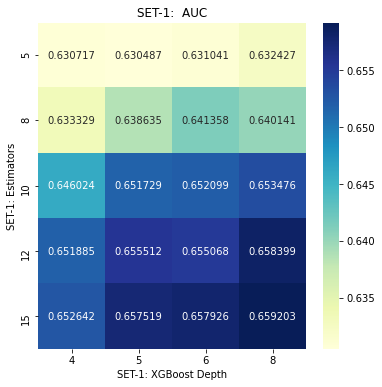

In [31]:
plt.figure(figsize=(6,6)) 
#do sns plot
sns.heatmap(np.array(set_1_auc_score).reshape(5,4),annot=True, xticklabels=random_maximum_depth, yticklabels=random_estimators,cmap="YlGnBu",fmt='.6f')
plt.xlabel("SET-1: XGBoost Depth")
plt.ylabel("SET-1: Estimators") 
plt.title("SET-1:  AUC") 
#finally display
plt.show()

In [34]:
# doing on best parmas:   {'max_depth': 8, 'num_estimators': 15}
set_1_best_model_xgb = XGBClassifier(learning_rate =0.1, n_estimators=15,max_depth=8,subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, seed=27)
#model fitting
set_1_best_model_xgb.fit(x_train, y_train.values)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=15, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.23606797749979, seed=27, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

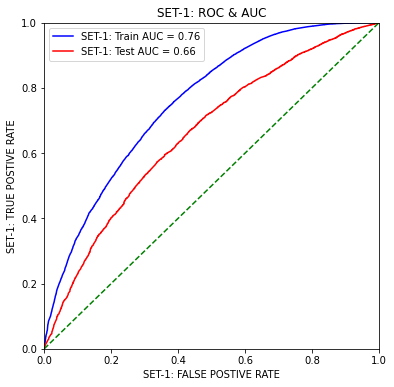

In [37]:
#doing final predictions
set_1_train_predict = set_1_best_model_xgb.predict(x_train) 
set_1_test_predict = set_1_best_model_xgb.predict(x_test)
#doing model predictions 
set_1_train_proba = set_1_best_model_xgb.predict_proba(x_train) 
set_1_test_proba = set_1_best_model_xgb.predict_proba(x_test)
#doing roc cureve
set_1_train_fpr, set_1_train_tpr, set_1_train_f = roc_curve(y_train.values, train_proba[:,1]) 
set_1_test_fpr, set_1_test_tpr, set_1_test_f = roc_curve(y_test.values, test_proba[:,1])
#doing roc & auc curve
set_1_train_auc_score = roc_auc_score(y_train.values, train_proba[:,1]) 
set_1_test_auc_score = roc_auc_score(y_test.values, test_proba[:,1])
#finally poltting details
plt.figure(figsize=(6,6))
plt.plot(set_1_train_fpr, set_1_train_tpr,'b',label = "SET-1: Train AUC = {}".format(np.round(set_1_train_auc_score,2))) 
plt.plot(set_1_test_fpr, set_1_test_tpr,'r', label = "SET-1: Test AUC = {}".format(np.round(set_1_test_auc_score,2))) 
#labels
plt.xlabel("SET-1: FALSE POSTIVE RATE")
plt.ylabel("SET-1: TRUE POSTIVE RATE")
plt.title("SET-1: ROC & AUC")
plt.legend()
#diaplay details
plt.show()

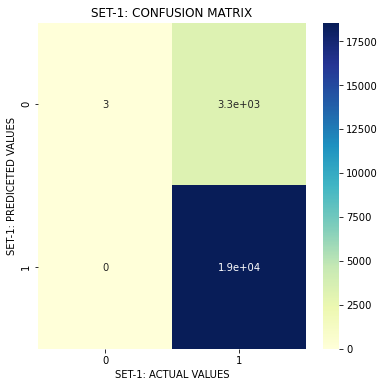

In [38]:
#plot values
set_1_cf = confusion_matrix(y_test.values, test_predict)
#plot details
plt.figure(figsize=(6,6))
sns.heatmap(set_1_cf, annot= True, xticklabels=[0,1], yticklabels=[0,1],cmap="YlGnBu") 
# plot titles
plt.xlabel("SET-1: ACTUAL VALUES")
plt.ylabel("SET-1: PREDICETED VALUES")
plt.title("SET-1: CONFUSION MATRIX")
#diaply graphs
plt.show()

In [39]:
#finally display records
set_1_table = PrettyTable()
set_1_table.title = "SET-1: XGBoost MODEL with tfidf"
set_1_table.field_names = ["Model","Train AUC","Test AUC"] 
set_1_table.add_row(["SET-1: XGBoost tfidf", train_auc_score,test_auc_score])
print(set_1_table)

+----------------------+--------------------+--------------------+
|        Model         |     Train AUC      |      Test AUC      |
+----------------------+--------------------+--------------------+
| SET-1: XGBoost tfidf | 0.7569688462552797 | 0.6589467152385963 |
+----------------------+--------------------+--------------------+


In [66]:
#set-2 tfidf vectorizer
set_2_tfidf_project_essay = TfidfVectorizer()
#fit data
set_2_x_train_essay = tfidf_project_essay.fit_transform(train_df["essay"]) 
#transform data
set_2_x_cv_essay = tfidf_project_essay.transform(cv_df["essay"]) 
set_2_x_test_essay = tfidf_project_essay.transform(test_df["essay"])

In [ ]:
def set_2_get_set_2_w2v_representation(feature_type = "title"): 
    set_2_feature_idf_dict = dict()
    set_2_feature_idf_dict = dict(zip(set_2_tfidf_project_essay.get_feature_names(),set_2_tfidf_project_essay.idf_))
    #looping through  each set records
    for ele, type in enumerate([train_df, cv_df, test_df]): 
        set_2_rows = 0
        set_2_w2v = []
        #looping through each feature details
        for each_sentence in type[feature_type].values:
            each_sent_each_vec = np.zeros(300) 
            each_weighted_tfidf = 0
            #lopping through each word in sentences
            for each_word in each_sentence.split(" "):
                #calucalte w2v for each word
                if each_word in list(each_word2each_vec_model.wv.vocab) and each_word in list(set_2_feature_idf_dict.keys()):
                    each_vec = ord2each_vec_model.wv[each_word]
                    each_tf_idf = set_2_feature_idf_dict[each_word] * (each_sentence.count(each_word) / len(each_sentence)) 
                    each_sent_each_vec += (each_vec * each_tf_idf)
                    each_weighted_tfidf += each_tf_idf
            #calclulate tfiddf values
            if each_weighted_tfidf != 0: 
                each_sent_each_vec /= each_weighted_tfidf
            set_2_w2v.append(each_sent_each_vec)
            set_2_rows+=1 
        yield set_2_w2v
#get set-2 details     
train_essay_set_2_w2v, cv_essay_set_2_w2v, test_essay_set_2_w2v = set_2_get_set_2_w2v_representation("essay")

In [42]:
set_2_x_train_text_w2v.shape, set_2_x_cv_text_w2v.shape, set_2_x_test_text_w2v.shape

((69918, 300), (17480, 300), (21850, 300))

In [43]:
set_2_x_train = np.hstack((set_2_x_train_categorical_and_numeric,set_2_x_train_text_w2v)) 
set_2_x_cv = np.hstack((set_2_x_cv_categorical_and_numeric,set_2_x_cv_text_w2v))
set_2_x_test = np.hstack((set_2_x_test_categorical_and_numeric,set_2_x_test_text_w2v))

In [44]:
set_2_start_time = time()
set_2_best_auc = 0.0 
set_2_best_params = {} 
set_2_auc_score = []
set_2_data_balance = np.sqrt(int(train_df.project_is_approved.value_counts()[1]/train_df.project_is_approved.value_counts()[0]))
set_2_num_estimators = [5,8,10,12,15]
set_2_maximum_depth = [4,5,6,8]
for wach_estimator in tqdm(set_2_num_estimators): 
    for each_depth in set_2_maximum_depth:
        set_2_xgb = XGBClassifier(learning_rate =0.1, wach_estimatorimators=wach_estimator,max_depth=each_depth, subsample=0.7, colsample_bytree=0.7, objective= 'binary:logistic', nthread=4,seed=27,scale_pos_weight=set_2_data_balance) 
        set_2_xgb.fit(x_train, y_train.values)
        set_2_train_predicted = set_2_xgb.predict(x_train) 
        set_2_cv_predicted = set_2_xgb.predict(x_cv)
        set_2_train_proba = set_2_xgb.predict_proba(x_train) 
        set_2_cv_proba = set_2_xgb.predict_proba(x_cv)
        set_2_train_auc = roc_set_2_auc_score(y_train.values, set_2_train_proba[:,1]) 
        set_2_cv_auc = roc_set_2_auc_score(y_cv.values, set_2_cv_proba[:,1])
        if set_2_cv_auc > set_2_best_auc:
            set_2_best_auc = set_2_cv_auc
            set_2_best_params = {"max_depth": each_depth,"set_2_num_estimators":wach_estimator} 
        set_2_auc_score.append(set_2_cv_auc)

100%|██████████| 5/5 [01:09<00:00, 13.82s/it]


In [47]:
set_2_table = PrettyTable()
set_2_table.title = "SET-2: XGBoost + W2V"
set_2_table.field_names = ["Best parameters","Best score","TIME"] 
set_2_table.add_row(["{'max_depth': 8, 'num_estimators': 15}", best_auc ,(time()-set_2_start_time)])
print(table)

+----------------------------------------+--------------------+-------------------+
|            Best parameters             |     Best score     |        TIME       |
+----------------------------------------+--------------------+-------------------+
| {'max_depth': 8, 'num_estimators': 15} | 0.5992852269305993 | 84.31265568733215 |
+----------------------------------------+--------------------+-------------------+


In [ ]:
plt.ylabel("SET-2: XGBoost + W2V ==> Estimator") 


In [ ]:
plt.figure(figsize=(6,6)) 
sns.heatmap(np.array(set_2_auc_score).reshape(5,4),annot=True,xticklabels=set_2_maximum_depth,yticklabels=set_2_num_estimators) 
plt.xlabel("SET-2: XGBoost + W2V ==> Depth")
plt.ylabel("SET-2: XGBoost + W2V ==> Estimator") 
plt.title("SET-2: XGBoost + W2V ==> AUC Score") 
plt.show()

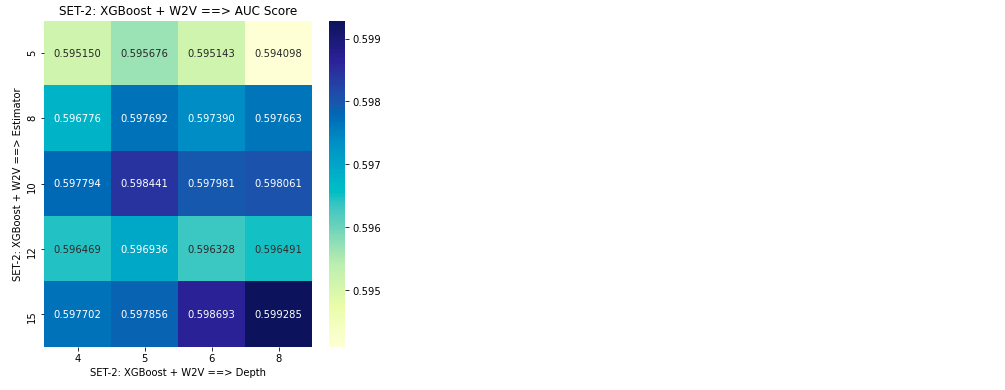

In [49]:
set_2_best_xgb = XGBClassifier(learning_rate =0.1, n_estimators=15,max_depth=6,subsample=0.7, colsample_bytree=0.7, objective= 'binary:logistic', nthread=4,seed=27, scale_pos_weight=data_balance)
set_2_best_xgb.fit(x_train, y_train.values)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=15, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.23606797749979, seed=27, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
# set_2_best_xgbtrain_predict = xgb.predict(set_2_best_xgbx_train) 
# set_2_best_xgbtest_predict = xgb.predict(set_2_best_xgbx_test)
# set_2_best_xgbtrain_proba = xgb.predict_proba(set_2_best_xgbx_train) 
# set_2_best_xgbtest_proba = xgb.predict_proba(set_2_best_xgbx_test)

# set_2_best_xgbtrain_fpr, set_2_best_xgbtrain_tpr, set_2_best_xgbtrain_f = roc_curve(set_2_best_xgby_train.values, set_2_best_xgbtrain_proba[:,1]) 
# set_2_best_xgbtest_fpr, test_tpr, set_2_best_xgbtest_f = roc_curve(set_2_best_xgby_test.values, set_2_best_xgbtest_proba[:,1])
# set_2_best_xgbtrain_auc_score = roc_auc_score(set_2_best_xgby_train.values, set_2_best_xgbtrain_proba[:,1]) 
# set_2_best_xgbtest_auc_score = roc_auc_score(set_2_best_xgby_test.values, set_2_best_xgbtest_proba[:,1])

(0.0, 1.0)

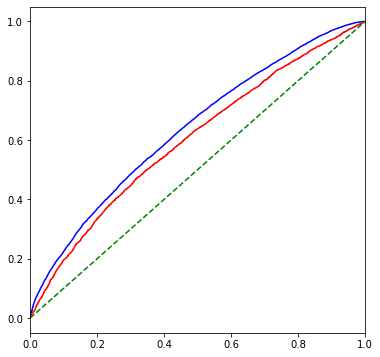

In [51]:
# predict values
set_2_best_xgbtrain_predict = xgb.predict(set_2_best_xgbx_train) 
set_2_best_xgbtest_predict = xgb.predict(set_2_best_xgbx_test)

#predict prop values
set_2_best_xgbtrain_proba = xgb.predict_proba(set_2_best_xgbx_train) 
set_2_best_xgbtest_proba = xgb.predict_proba(set_2_best_xgbx_test)
#roc values
set_2_best_xgbtrain_fpr, set_2_best_xgbtrain_tpr, set_2_best_xgbtrain_f = roc_curve(set_2_best_xgby_train.values, set_2_best_xgbtrain_proba[:,1]) 
set_2_best_xgbtest_fpr, test_tpr, set_2_best_xgbtest_f = roc_curve(set_2_best_xgby_test.values, set_2_best_xgbtest_proba[:,1])
#roc and auc values
set_2_best_xgbtrain_auc_score = roc_auc_score(set_2_best_xgby_train.values, set_2_best_xgbtrain_proba[:,1]) 
set_2_best_xgbtest_auc_score = roc_auc_score(set_2_best_xgby_test.values, set_2_best_xgbtest_proba[:,1])

#finall ydefine plots
plt.figure(figsize=(6,6))
plt.plot(set_2_best_xgbtrain_fpr, set_2_best_xgbtrain_tpr,'b',label = "SET-2 (XGBoost + W2V): train auc = {}".format(np.round(set_2_best_xgbtrain_auc_score,2))) 
plt.plot(set_2_best_xgbtest_fpr, set_2_best_xgbtest_tpr,'r', label = "SET-2 (XGBoost + W2V): test auc = {}".format(np.round(set_2_best_xgbtest_auc_score,2))) 
#display plots
plt.show()

In [88]:
#set-2 confusion matrix details
set_2_best_cf = confusion_matrix(y_test.values, test_predict)

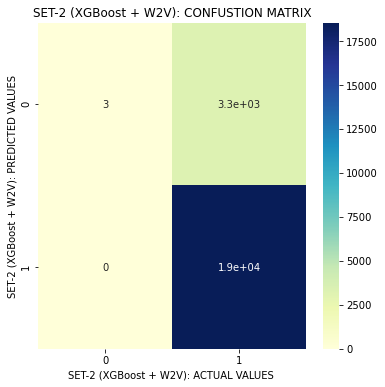

In [53]:
#get the set-2 details 
plt.figure(figsize=(6,6))
#make the heatmap details
sns.heatmap(set_2_best_cf, annot= True, xticklabels=[0,1], yticklabels=[0,1],cmap="YlGnBu") 
plt.xlabel("SET-2 (XGBoost + W2V): ACTUAL VALUES ")
plt.ylabel("SET-2 (XGBoost + W2V): PREDICTED VALUES")
plt.title("SET-2 (XGBoost + W2V): CONFUSTION MATRIX")
#finally display the plot
plt.show()

In [55]:
all_sets_table = PrettyTable()
all_sets_table.field_names = ["Model","Train AUC","Test AUC"] 
all_sets_table.add_row(["SET-1: XGBoost + tfidf", set_1_train_auc_score,set_1_test_auc_score])
all_sets_table.add_row(["SET-2: XGBoost +  w2v", set_2_train_auc_score,set_2_test_auc_score])
print(all_sets_table)

+------------------------+--------------------+--------------------+
|         Model          |     Train AUC      |      Test AUC      |
+------------------------+--------------------+--------------------+
| SET-1: XGBoost + tfidf | 0.7569688462552797 | 0.6589467152385963 |
| SET-2: XGBoost +  w2v  | 0.6360663972800201 | 0.6004332854187564 |
+------------------------+--------------------+--------------------+


## Observations
    1. If we do increase data and balance classes model performs better
    2. If we do more feature selection technies then negative class get easily classified